Checking encoder decoder conv nets for sunnybrook data - mymodel

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from keras import backend as K
import cv2
from keras.preprocessing.image import ImageDataGenerator
import pickle
from keras.callbacks import ModelCheckpoint
from skimage import img_as_ubyte

Using TensorFlow backend.


In [0]:
#import skimage.io as io
#import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [0]:
seed = 1234
np.random.seed(seed)

startDir = 'drive/My Drive/Pickled_data/'
weights_dir = startDir

In [0]:
def show_images(images, dpi = 72, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    plt.rcParams['figure.dpi'] = dpi
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    plt.rcParams['figure.dpi'] = 72

In [0]:
def plot_images(images, rows =1):
    plt.close('all')
    DPI = plt.rcParams['figure.dpi']
    fs = plt.rcParams['figure.figsize']
    dpi_per_row = int(DPI/6)
    dpi = dpi_per_row * rows
    dpi_factor = int(dpi/DPI)
    
    n_images = len(images)
    cols = int(n_images/rows)
    ratio = cols/rows
    plt.rcParams['figure.figsize'] =  (int(ratio*cols),cols) #(28,28)
        
    fig, ax = plt.subplots(rows, cols, sharex='col', sharey='row')
    #fig.subplots_adjust(wspace=0.0, hspace=0.0)
    #print(rows, cols)
    for x, y in [(i, j) for i in range(rows) for j in range(cols)]:
        #pass
        #print(x,y)
        #ax[x, y].imshow(images[x*rows + y].reshape((28, 28)), cmap = 'gray')
        ax[x, y].imshow(images[x*rows + y], cmap = 'gray')
    #plt.tight_layout()
    plt.show()
    plt.rc('figure', figsize=fs)
    plt.rcParams['figure.dpi'] = DPI

In [0]:
def addmask_border(img, msk, clr = (255,255,0), thickness = 1):
    image = img.copy()
    if np.ndim(image) == 2:
      #image = image.astype('uint8')
      image = img_as_ubyte(image)
      image = cv2.cvtColor(image,cv2.COLOR_GRAY2BGR)
    bmsk = msk.copy().astype('uint8')
    _, contours, _ = cv2.findContours(bmsk, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
      lenctrs = [len(ctr) for ctr in contours]
      maxctridx = np.argmax(lenctrs)
      pts = np.array([pt[0] for pt in contours[maxctridx]])
      cv2.polylines(image,[pts],True,clr, thickness = thickness)
    return(image)

In [0]:
# draw images with ndim 3 with shape (x,x,1)
def draw_images(imgs, titles = None, dpi = 72):
  simgs = []
  for i in range(len(imgs)):
    simg = np.squeeze(imgs[i])
    simgs.append(simg)
  show_images(simgs, titles=titles, dpi = dpi)

In [0]:
def draw_overlap_border(image, mask, dpi = 72, thickness = 1, clr = (255,0,0), title = ['border in red'] ):
  img1 = np.squeeze(image)
  img2 = np.squeeze(mask)
  bimg1 = addmask_border(img1, img2, clr = clr, thickness = thickness)
  show_images([bimg1],titles=title, dpi = dpi)

In [0]:
def find_overlap_border(image, mask, thickness = 1, clr = (255,0,0)):
  img1 = np.squeeze(image)
  img2 = np.squeeze(mask)
  bimg1 = addmask_border(img1, img2, clr = clr, thickness = thickness)
  return(bimg1)

In [0]:
def find_border(chkidx, imgarr, mskarr, clr=(255,255,0), thickness = 1):
  img1 = imgarr[chkidx]
  img1 = np.squeeze(img1)
  img2 = mskarr[chkidx]
  img2 = np.squeeze(img2)
  img2 = np.array(img2, dtype=np.uint8)
  img3 = addmask_border(img1,img2,clr=clr,thickness = thickness)
  #img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)
  return(img3)

In [0]:
def get_imagestodraw(idx, imgarr, mskarr, predarr):
    idx = idx
    img_border = find_border(idx, imgarr, mskarr, thickness = 2, clr = (255,255,0))
    img_border = find_overlap_border(img_border, predarr[idx], thickness = 2, clr = (255,0,0))
    #print(img_border.shape)

    msk_t = mskarr[idx]
    msk_t = np.squeeze(msk_t)
    msk_t = np.array(msk_t, dtype=np.uint8)
    msk_t[msk_t==1] = 255
    msk_t = cv2.cvtColor(msk_t,cv2.COLOR_GRAY2BGR)
    msk_t[np.where((msk_t==[255,255,255]).all(axis=2))] = [255,255,0]

    msk_p = predarr[idx]
    msk_p = np.squeeze(msk_p)
    msk_p = np.where(msk_p > 0.6,255.0,0.0)
    msk_p = np.array(msk_p,dtype=np.uint8)
    msk_p = cv2.cvtColor(msk_p,cv2.COLOR_GRAY2BGR)
    msk_p[np.where((msk_p==[255,255,255]).all(axis=2))] = [255,0,0]

    img_t = imgarr[idx]
    img_t = np.squeeze(img_t)
    img_t = img_as_ubyte(img_t)
    img_t = cv2.cvtColor(img_t,cv2.COLOR_GRAY2BGR)
    img_tm = img_t.copy()
    img_tm[(msk_t==[255,255,0]).all(axis=2)] = [255,255,0]
    img_tp = img_t.copy()
    img_tp[(msk_p==[255,0,0]).all(axis=2)] = [255,0,0]

    overlay = img_tm
    alpha = 0.5
    output = img_border   # img_t
    output_img = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0)
    alpha = 0.5
    overlay = img_tp   # msk_p
    output_img = cv2.addWeighted(overlay, alpha, output_img, 1 - alpha, 0)
    return (img_t, img_tm, img_tp, img_border, output_img)

In [0]:
def plot_training(results, loss1 = 'loss', mon1 = 'val_loss', mon2 = ''):
  plt.figure(figsize=(8, 8))
  plt.title("Learning curve")
  plt.plot(results.history[loss1], label=loss1)
  if mon1 in results.history.keys():
    plt.plot(results.history[mon1], label=mon1)
  if mon2 != '':
    if mon2 in results.history.keys():
      plt.plot(results.history[mon2], label=mon2)
  plt.xlabel("Epochs")
  plt.ylabel("loss/mon")
  plt.legend();

In [0]:
def store_output_images(imgcnt = 1, dictofimgs={'orig':None,'amsk':None,'pmsk':None,'bimg':None,'oimg':None}):
  thiscnt = 1
  for k in dictofimgs.keys():
    if dictofimgs[k] is None:
      pass
    else:
      fn = startDir + k + '_' + str(imgcnt) + '.png'
      img = dictofimgs[k]
      img  = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      cv2.imwrite(fn,img)
      thiscnt += 1

In [0]:
# load arrays from pickle files
def load_pickled_data():
  
  image_train_pickle_file = startDir + 'image_train.pkl'
  image_dev_pickle_file = startDir + 'image_dev.pkl'
  image_test_pickle_file = startDir + 'image_test.pkl'
  mask_train_pickle_file = startDir + 'mask_train.pkl'
  mask_dev_pickle_file = startDir + 'mask_dev.pkl'
  mask_test_pickle_file = startDir + 'mask_test.pkl'

  with open(image_train_pickle_file, 'rb') as f:
    image_train = pickle.load(f)
  with open(image_dev_pickle_file, 'rb') as f:
    image_dev = pickle.load(f)
  with open(image_test_pickle_file, 'rb') as f:
    image_test = pickle.load(f)

  with open(mask_train_pickle_file, 'rb') as f:
    mask_train = pickle.load(f)
  with open(mask_dev_pickle_file, 'rb') as f:
    mask_dev = pickle.load(f)
  with open(mask_test_pickle_file, 'rb') as f:
    mask_test = pickle.load(f)
  return image_train, image_dev, image_test, mask_train, mask_dev,mask_test

In [0]:
# Model loss and monitor functions

def dice_coef(y_true, y_pred, smooth=0.0):
    '''Average dice coefficient per batch.'''
  
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def jaccard_coef(y_true, y_pred, smooth=0.0):
    '''Average jaccard coefficient per batch.'''
 
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)
  
def dice_loss(smooth):
  def dice(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=smooth)
  return dice

def dice_mon(smooth):
  def dicemon(y_true, y_pred):
    return dice_coef(y_true, y_pred, smooth=smooth)
  return dicemon

def jaccard_mon(smooth):
  def jaccardmon(y_true, y_pred):
    return jaccard_coef(y_true, y_pred, smooth=smooth)
  return jaccardmon

In [0]:
def conv_block(layer_before, features, block_no = 0, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform', pool_bool = True):
  if pool_bool:
    block = '_convblock_'+str(block_no)
  else:
    block = '_middleblock'
  conv = Conv2D(features, 3, activation = activation, padding = padding, kernel_initializer = kernel_initializer, name = 'conv1'+block)(layer_before)
  conv = BatchNormalization()(conv)
  conv = Conv2D(features, 3, activation = activation, padding = padding, kernel_initializer = kernel_initializer, name = 'conv2'+block)(conv)
  conv = BatchNormalization()(conv)
  if pool_bool:
    conv = MaxPooling2D(pool_size=(2, 2), name = 'pool'+block)(conv)
  return conv

In [0]:
def deconv_block(layer_before, features, block_no = 0, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform'):
  if block_no == 0:
    conv = Conv2D(2, 3, activation = activation, padding = padding, kernel_initializer = kernel_initializer)(layer_before)
    return conv
  block = '_deconvblock_'+str(block_no)
  up = UpSampling2D(size = (2,2), name = 'up'+block)(layer_before)
  conv = Conv2D(features, 2, activation = activation, padding = padding, kernel_initializer = kernel_initializer, name = 'conv1'+block)(up)
  conv = BatchNormalization()(conv)
  conv = Conv2D(features, 3, activation = activation, padding = padding, kernel_initializer = kernel_initializer, name = 'conv2'+block)(conv)
  conv = BatchNormalization()(conv)
  return conv

In [0]:
def encoder(input_layer, starting_features = 64, depth=4):
  conv = input_layer
  features = starting_features
  for i in range(depth):
    conv = conv_block(conv,features, block_no=i+1)
    features *= 2
  return conv, features

def middle_layer(input_conv, features):
  return conv_block(input_conv, features, pool_bool=False)

def decoder(input_conv, features=1024, height=4):
  conv = input_conv
  features = int(features/2)
  for i in range(height):
    conv = deconv_block(conv,features, block_no=i+1)
    features = int(features/2)
  conv = deconv_block(conv,features,block_no=0)
  return conv
  

In [0]:
def build_model(input_size = (256,256,1), depth = 4):
  inputs = Input(input_size)
  conv, features = encoder(inputs, depth=depth)
  middle_conv = middle_layer(conv,features)
  conv = decoder(middle_conv, features = features, height = depth)
  out = Conv2D(1, 1, activation = 'sigmoid')(conv)

  model = Model(inputs = inputs, outputs = out)

  return model

In [0]:
def compile_model(depth = 4):
  
  model = build_model(depth=depth)
  smooth=K.epsilon()   #10.0
  model_dice = dice_loss(smooth=smooth)    #smooth=K.epsilon()
  dicemon = dice_mon(smooth)
  jaccardmon = jaccard_mon(smooth)
  sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
  model.compile(optimizer = sgd, loss = model_dice, metrics = [dicemon, jaccardmon])  # Adam(lr = 1e-4),
  return model

In [0]:
def get_prepare_data():
  image_train, image_dev, image_test, mask_train, mask_dev,mask_test = load_pickled_data()
  # convert to float

  mask_train = np.where(mask_train>128, 1.0, 0.0)
  mask_dev = np.where(mask_dev>128, 1.0, 0.0)
  mask_test = np.where(mask_test>128, 1.0, 0.0)

  image_train = image_train / 255
  image_dev = image_dev / 255
  image_test = image_test / 255
  
  return image_train, image_dev, image_test, mask_train, mask_dev,mask_test

In [0]:
model = compile_model(depth = 5)

In [0]:
image_train, image_dev, image_test, mask_train, mask_dev,mask_test = get_prepare_data()

In [0]:
# define data generators
kwargs = dict(
        rotation_range=180,
        zoom_range=0.0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,
    )

image_datagen = ImageDataGenerator(**kwargs)
mask_datagen = ImageDataGenerator(**kwargs)
val_image_datagen = ImageDataGenerator(**kwargs)
val_mask_datagen = ImageDataGenerator(**kwargs)

mini_batch_size = 1

image_generator = image_datagen.flow(image_train, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
mask_generator = mask_datagen.flow(mask_train, shuffle=False,
                                batch_size=mini_batch_size, seed=seed)
train_generator = zip(image_generator, mask_generator)

val_image_generator = val_image_datagen.flow(image_dev, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
val_mask_generator = val_mask_datagen.flow(mask_dev, shuffle=False,
                                batch_size=mini_batch_size, seed=seed)
val_generator = zip(val_image_generator, val_mask_generator)

In [0]:
model_name = '_ecdc5_model' 
weights_file = weights_dir + 'sunnybrook'+model_name+'-{epoch:02d}.hdf5' 
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_dicemon',verbose=1, period=5)  #, save_best_only=True)

In [96]:
epochs = 10
hist = model.fit_generator(train_generator,steps_per_epoch=2000,epochs=epochs,callbacks=[model_checkpoint], validation_data=val_generator, validation_steps=200)

Epoch 1/10
2000/2000 [==============================] - 779s 389ms/step - loss: 0.5242 - dicemon: 0.4758 - jaccardmon: 0.3415 - val_loss: 0.5707 - val_dicemon: 0.4293 - val_jaccardmon: 0.3101
Epoch 2/10
2000/2000 [==============================] - 772s 386ms/step - loss: 0.4362 - dicemon: 0.5638 - jaccardmon: 0.4176 - val_loss: 0.6292 - val_dicemon: 0.3708 - val_jaccardmon: 0.2697
Epoch 3/10
2000/2000 [==============================] - 773s 386ms/step - loss: 0.4295 - dicemon: 0.5705 - jaccardmon: 0.4240 - val_loss: 0.5757 - val_dicemon: 0.4243 - val_jaccardmon: 0.3046
Epoch 4/10
2000/2000 [==============================] - 772s 386ms/step - loss: 0.4262 - dicemon: 0.5738 - jaccardmon: 0.4278 - val_loss: 0.5404 - val_dicemon: 0.4596 - val_jaccardmon: 0.3337
Epoch 5/10
2000/2000 [==============================] - 771s 385ms/step - loss: 0.4233 - dicemon: 0.5767 - jaccardmon: 0.4312 - val_loss: 0.4975 - val_dicemon: 0.5025 - val_jaccardmon: 0.3699

Epoch 00005: saving model to drive/My D

In [97]:
hist.history.keys()

dict_keys(['val_loss', 'val_dicemon', 'val_jaccardmon', 'loss', 'dicemon', 'jaccardmon'])

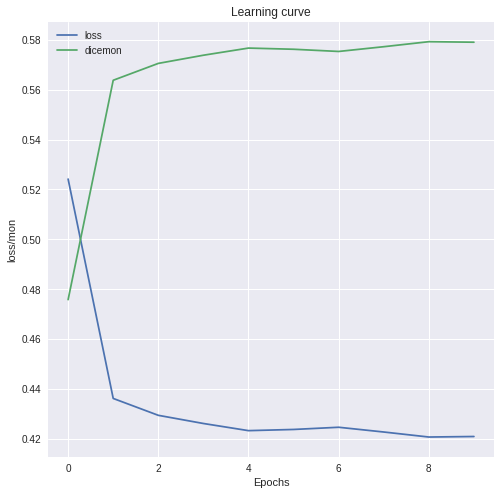

In [99]:
plot_training(hist,mon1='dicemon')

In [0]:
model_p = build_model(depth=5)
epoch_count = 10
mymodel = '_ecdc5_model' 
weights_file = weights_dir + 'sunnybrook'+mymodel+'-{:02d}.hdf5'.format(epoch_count)
model_p.load_weights(weights_file)

In [101]:
pred_masks = model_p.predict(image_test, batch_size=1, verbose=1)

25/25 [==============================] - 4s 153ms/step


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


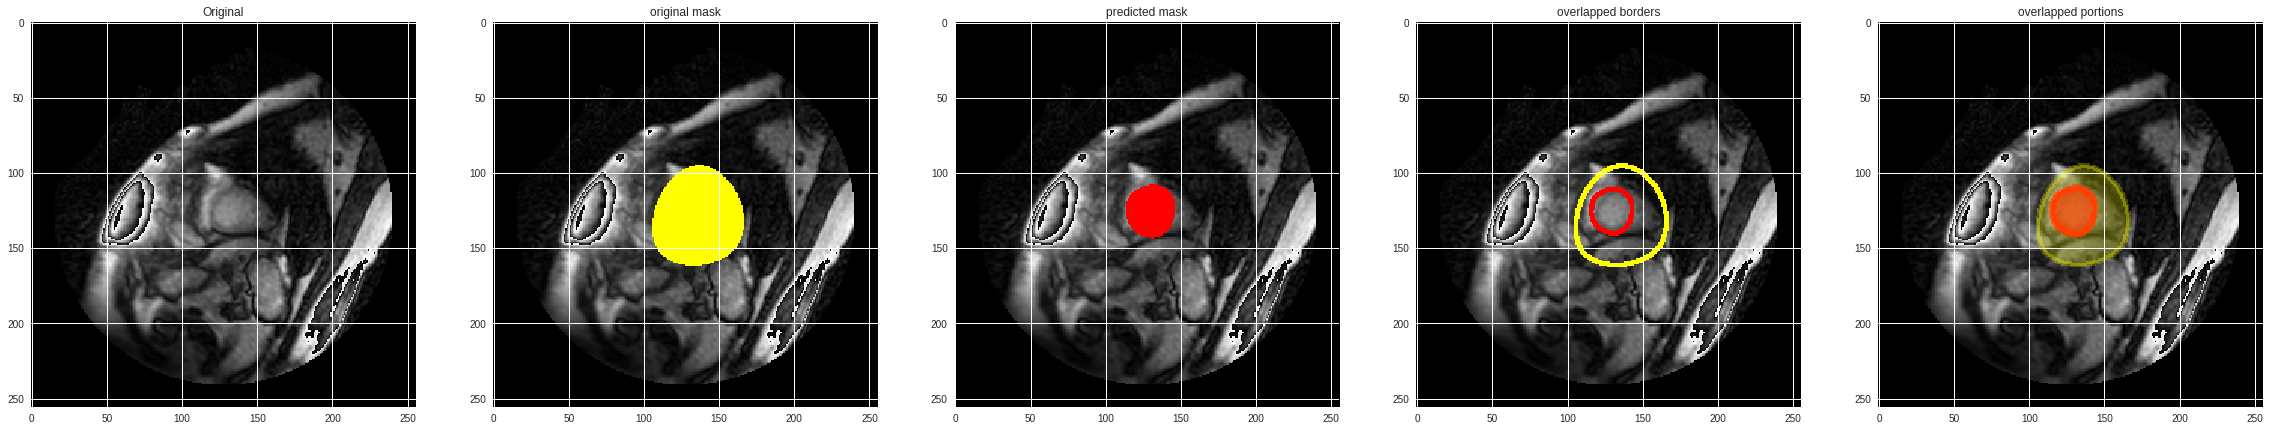

In [35]:
idx = 1
img_t, img_tm, img_tp, img_border, output_img = get_imagestodraw(idx, image_test, mask_test, pred_masks)
show_images([img_t,  img_tm, img_tp, img_border, output_img], titles = ['Original','original mask', 'predicted mask', 'overlapped borders', 'overlapped portions'])

In [0]:
def plot_rows_cols(imgs,ttls=[]):
  ofs = plt.rcParams['figure.figsize'] 
  fig=plt.figure(figsize=(16, 16))
  columns = 5
  rows = int(len(imgs)/columns)
  ax = []
  for i in range(1, columns*rows +1):
      img = imgs[i-1]
      ax.append(fig.add_subplot(rows, columns, i))
      if ttls != [] and len(imgs) == len(ttls):
        ax[-1].set_title(ttls[i-1]) 
      plt.imshow(img)
  plt.subplots_adjust(bottom=0.3,hspace=0)
  plt.show()
  plt.rcParams['figure.figsize'] = ofs

In [109]:
allimgs = []
for idx in range(3,6):
  imgs = get_imagestodraw(idx, image_test, mask_test, pred_masks)
  allimgs.extend(list(imgs))

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [0]:
hdrs = ['orig','mask','pred','borders','overlaps']
ttls = []
nos = int(len(allimgs)/5)
for i in range(nos):
  ttls.extend(hdrs)

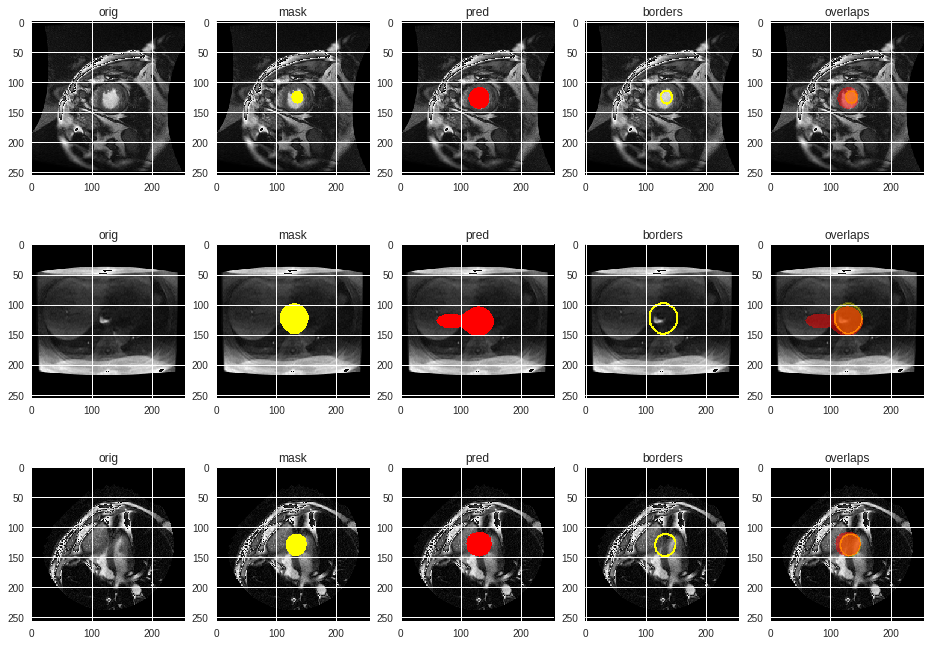

In [111]:
plot_rows_cols(allimgs,ttls)